# Experiment 2 - Minimum Balancing with 64x64 Resizing with Data Augmentation

This experiment consists on the pre-processing data pipeline established below:

- Data Balancing with Reduction + Oversampling, resulting in 2,100 training images as final dataset.
- Image Resizing to 64x64 in order to improve performance.
- Pixel Values Normalisation to range 0 to 1.
- Data Augmentation layers added.

## Initial Setup

This initial setup is used to allow direct import of classes from other Notebooks available on Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

## Libraries Import

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
from isic2018_task3_models import BaseModel
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Instances of the class

In [4]:
db = DataBalancer()
dp = DataPreparer()
msp = ModelSpecificProcessor()

## Train Data Pre-Processing

### Capture and prepare labels data

In this step, the csv file containing diagnosis of lesion type is captured into a dataframe and transformed to provide labels in a single lesion type feature, encode categorical labels, and store image full path based on Google Drive folder structure.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df = dp.labelPathMapper(df, 'train')
df.head()

,image,lesion_type,label_encoded,img_path
0,ISIC_0024306,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,MEL,1,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [7]:
# Check for any issues with img_path
missing_files = [f for f in df['img_path'].values if not os.path.exists(f)]
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print("Example missing path:", missing_files[0])

Missing files: 0


### Data Balancing

For this experiment, the data balance consists of capturing n random samples of each category where n = the record count of the smallest lesion type in the dataset. Based on ISIC 2018 Train Dataset, as observed in file ISIC2018_Task3_Data_Analysis, this corresponds to lesion DF with 115 records.<br><br>
There are 7 categories, which when sampled to 115 per categories provides 805 records. This is insufficient data for training purposes, therefore oversampling is performed to achieve 300 images per categories, providing 2,100 records for training.

In [8]:
df, ds_train = db.minBalancing(df)

<Axes: xlabel='label_encoded', ylabel='count'>

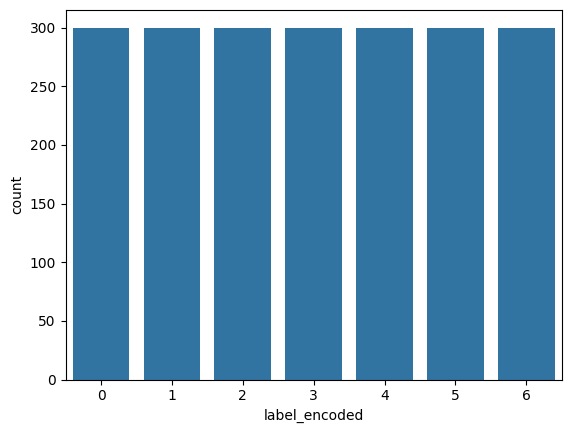

In [9]:
# Check df balance after balancing step
sns.countplot(x='label_encoded', data=df)

### Image Resizing and Normalisation

In [10]:
HEIGHT = 64
WIDTH = 64

def resize_wrapper(path, label):
    return dp.imageResizer(path, label, HEIGHT, WIDTH)

ds_train = ds_train.map(resize_wrapper)

In [11]:
ds_train = ds_train.map(dp.pixelNormalizer)

In [12]:
# Shuffle dataset to provide higher diversity per batch
ds_train = ds_train.shuffle(buffer_size=len(df))

In [13]:
BATCH_SIZE = 32

# Update shape to match model Sequential.call() shape
ds_train = ds_train.batch(BATCH_SIZE)

## Validation and Test Data Pre-Processing

In [14]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
df_validate = dp.labelPathMapper(df_validate, 'validate')

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
df_test = dp.labelPathMapper(df_test, 'test')

In [15]:
# Build image tensorflow dataset

ds_validate = db.buildDS(df_validate)
ds_test = db.buildDS(df_test)

In [16]:
# Image resizing 64x64

ds_validate = ds_validate.map(resize_wrapper)
ds_test = ds_test.map(resize_wrapper)

In [17]:
# Pixel values normalisation

ds_validate = ds_validate.map(dp.pixelNormalizer)
ds_test = ds_test.map(dp.pixelNormalizer)

In [18]:
# Update shape to match model Sequential.call() shape

ds_validate = ds_validate.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

## Model Building, Training and Validating

In [19]:
NUM_CLASSES = len(df.lesion_type.unique())
CHANNELS = 3
EPOCHS = 8

In [20]:
# Instance of Models class
bm = BaseModel(NUM_CLASSES, HEIGHT, WIDTH, CHANNELS)

In [21]:
data_aug_layers = dp.randomAugmentation()

In [22]:
# Function to support epoch plotting

def plot_hist(hist, modelName):
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title(f"{modelName} model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [23]:
# Function to support confusion matrix plotting

def conf_matrix(ds, model):
  y_true = []
  y_pred = []

  for images, labels in ds:
      preds = model.predict(images)
      y_true.extend(labels.numpy())
      y_pred.extend(np.argmax(preds, axis=1))
  cm = confusion_matrix(y_true, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  return disp

In [24]:
# Build Base Models

# Custom CNN Model
custom_CNN = bm.customCNN()
# EfficientNet Models
base_modelENB0 = bm.modelENB0()
base_modelENB4 = bm.modelENB4()
base_modelENB7 = bm.modelENB7()
base_modelENV2M = bm.modelENV2M()
# ResNet Models
base_modelRN50V2 = bm.modelRN50V2()
base_modelRN152V2 = bm.modelRN152V2()
# DenseNet Models
base_modelDN121 = bm.modelDN121()
base_modelDN201 = bm.modelDN201()

# Build custom Fully Connected Layer
custom_final_layer = bm.finalLayer()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Custom CNN

In [25]:
modelCNN = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    custom_CNN,
])

modelCNN.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelCNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 7)              │       692,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,807 (2.64 MB)

 Trainable params: 692,359 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
start_time = time.time()
histCNN = modelCNN.fit(ds_train, epochs=EPOCHS, validation_data=ds_validate)
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.2640 - loss: 2.1976 - val_accuracy: 0.0466 - val_loss: 3.2663
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 390ms/step - accuracy: 0.3573 - loss: 1.7336 - val_accuracy: 0.0363 - val_loss: 4.4570
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 443ms/step - accuracy: 0.4031 - loss: 1.5648 - val_accuracy: 0.0104 - val_loss: 3.6931
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step - accuracy: 0.4337 - loss: 1.4578 - val_accuracy: 0.0104 - val_loss: 4.1937
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.4814 - loss: 1.4303 - val_accuracy: 0.1036 - val_loss: 4.1236
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 448ms/step - accuracy: 0.5027 - loss: 1.3145 - val_accuracy: 0.1658 - val_loss: 3.4539
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.5189 - loss: 1.2280 - val_accuracy: 0.4041 - val_loss: 1.9606
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 401ms/step - accuracy: 0.4975 - loss: 1.3078 - val_accuracy: 0.36

In [27]:
loss, accuracy = modelCNN.evaluate(ds_validate)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.3459 - loss: 2.3998
Overall accuracy on validation set: 36.27%


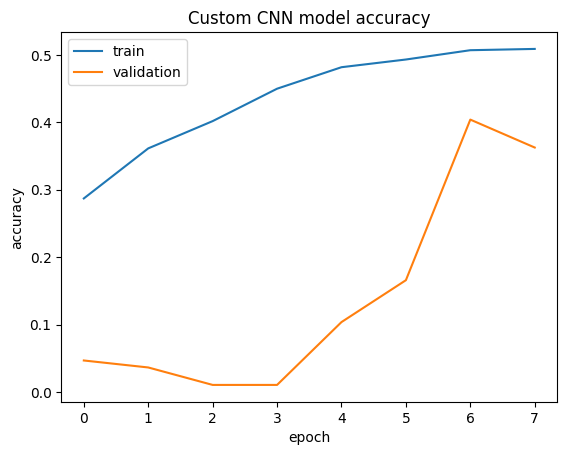

In [28]:
plot_hist(histCNN, "Custom CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


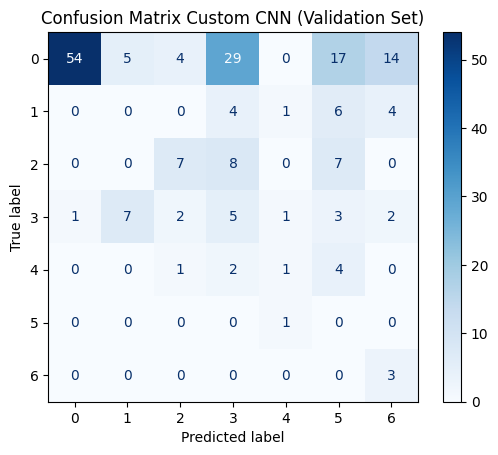

In [29]:
disp = conf_matrix(ds_validate, modelCNN)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Custom CNN (Validation Set)')
plt.show()

### EfficientNet Models

EfficientNet is a family of Convolutional Neural Networks (CNNs) that scales up models using compound coefficient, which uniformally scales each dimension with fixed coefficients, simultaneously increasing width, depth, and resolution.

In [25]:
ds_train_EN = ds_train.map(msp.efficientNetPrep)
ds_validate_EN = ds_validate.map(msp.efficientNetPrep)
ds_test_EN = ds_test.map(msp.efficientNetPrep)

#### EfficientNet-B0

In [44]:
modelENB0 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelENB0,
    layers.Flatten(),
    custom_final_layer,
])

modelENB0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENB0.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 7)              │       664,199 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,713,770 (17.98 MB)

 Trainable params: 4,671,747 (17.82 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [45]:
start_time = time.time()
hist = modelENB0.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B0 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.3461 - loss: 1.7157 - val_accuracy: 0.6373 - val_loss: 1.4478
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 137s 977ms/step - accuracy: 0.4809 - loss: 1.4123 - val_accuracy: 0.6373 - val_loss: 1.8742
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 958ms/step - accuracy: 0.5073 - loss: 1.3034 - val_accuracy: 0.0052 - val_loss: 2.7089
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 919ms/step - accuracy: 0.5640 - loss: 1.1806 - val_accuracy: 0.6373 - val_loss: 1.2941
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 956ms/step - accuracy: 0.6133 - loss: 1.0637 - val_accuracy: 0.0415 - val_loss: 2.8045
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 955ms/step - accuracy: 0.6406 - loss: 1.0199 - val_accuracy: 0.0311 - val_loss: 2.1607
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 919ms/step - accuracy: 0.6545 - loss: 0.9910 - val_accuracy: 0.0725 - val_loss: 1.6479
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 948ms/step - accuracy: 0.6662 - loss: 0.9459 - val_accuracy: 0.0

In [46]:
loss, accuracy = modelENB0.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.0813 - loss: 2.2839
Overall accuracy on validation set: 9.84%


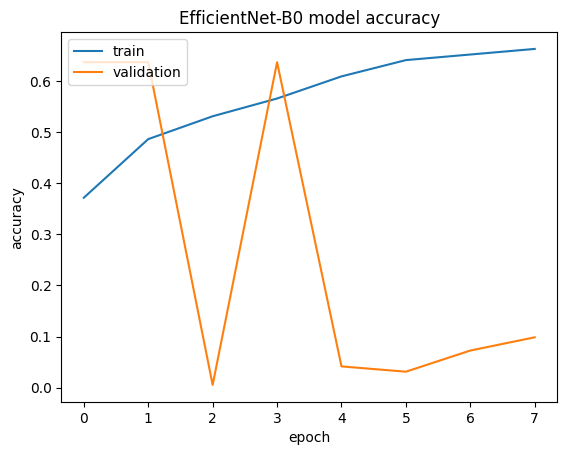

In [47]:
plot_hist(hist, "EfficientNet-B0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


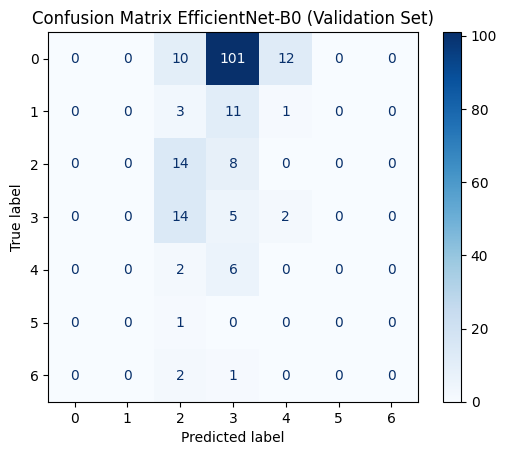

In [48]:
disp = conf_matrix(ds_validate_EN, modelENB0)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B0 (Validation Set)')
plt.show()

#### EfficientNet-B4

In [55]:
modelENB4 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelENB4,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENB4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENB4.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 2, 2, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,600,166 (70.95 MB)

 Trainable params: 18,474,959 (70.48 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [56]:
start_time = time.time()
histENB4 = modelENB4.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B4 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.2552 - loss: 1.9282 - val_accuracy: 0.1088 - val_loss: 2.1200
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.4809 - loss: 1.4265 - val_accuracy: 0.0052 - val_loss: 2.2402
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.5407 - loss: 1.2800 - val_accuracy: 0.6373 - val_loss: 1.6846
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.5302 - loss: 1.2656 - val_accuracy: 0.0777 - val_loss: 2.0226
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.5733 - loss: 1.1185 - val_accuracy: 0.0777 - val_loss: 1.9109
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.6017 - loss: 1.0977 - val_accuracy: 0.5959 - val_loss: 1.5507
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.6215 - loss: 1.0895 - val_accuracy: 0.0155 - val_loss: 3.7552
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.6600 - loss: 1.0189 - val_accuracy: 0.3679 - val_loss:

In [57]:
loss, accuracy = modelENB4.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - accuracy: 0.3819 - loss: 1.4874
Overall accuracy on validation set: 36.79%


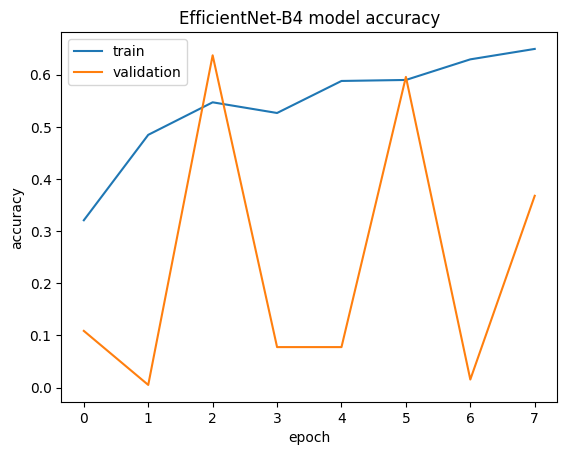

In [58]:
plot_hist(histENB4, "EfficientNet-B4")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


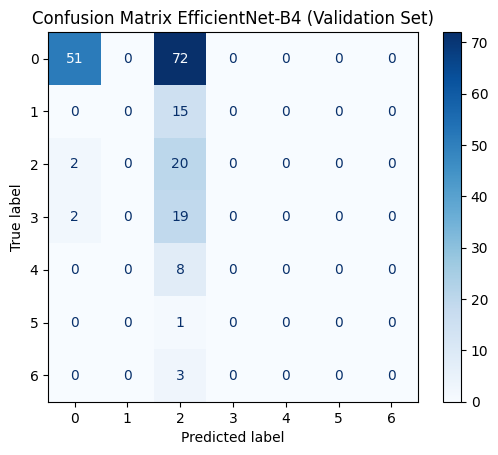

In [59]:
disp = conf_matrix(ds_validate_EN, modelENB4)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B4 (Validation Set)')
plt.show()

#### EfficientNet-B7

In [63]:
modelENB7 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelENB7,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENB7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENB7.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 2, 2, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,417,246 (249.55 MB)

 Trainable params: 65,106,519 (248.36 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [64]:
start_time = time.time()
histENB7 = modelENB7.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B7 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 925s 10s/step - accuracy: 0.2292 - loss: 2.0504 - val_accuracy: 0.1088 - val_loss: 2.2697
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 727s 10s/step - accuracy: 0.3988 - loss: 1.6002 - val_accuracy: 0.6373 - val_loss: 1.3398
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 693s 10s/step - accuracy: 0.4804 - loss: 1.4270 - val_accuracy: 0.0777 - val_loss: 1.7405
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 744s 10s/step - accuracy: 0.5239 - loss: 1.3087 - val_accuracy: 0.0984 - val_loss: 2.6816
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 734s 10s/step - accuracy: 0.5560 - loss: 1.2233 - val_accuracy: 0.0777 - val_loss: 2.9153
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 683s 10s/step - accuracy: 0.5584 - loss: 1.2550 - val_accuracy: 0.6373 - val_loss: 1.7408
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 683s 10s/step - accuracy: 0.5924 - loss: 1.1843 - val_accuracy: 0.0777 - val_loss: 1.8948
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 749s 10s/step - accuracy: 0.5622 - loss: 1.1906 - val_accuracy: 0.0777 - v

In [65]:
loss, accuracy = modelENB7.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1000 - loss: 1.8570
Overall accuracy on validation set: 7.77%


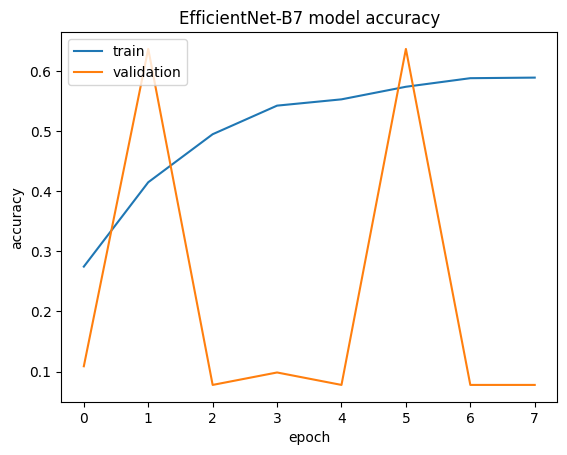

In [66]:
plot_hist(histENB7, "EfficientNet-B7")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


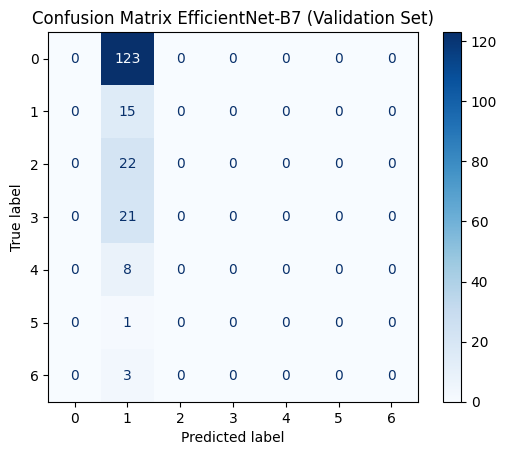

In [67]:
disp = conf_matrix(ds_validate_EN, modelENB7)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNet-B7 (Validation Set)')
plt.show()

#### EfficientNetV2-M

In [26]:
modelENV2M = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelENV2M,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelENV2M.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENV2M.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 2, 2, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,814,587 (205.29 MB)

 Trainable params: 53,522,555 (204.17 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [27]:
start_time = time.time()
histENV2M = modelENV2M.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNetV2-M Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 755s 7s/step - accuracy: 0.1905 - loss: 2.0341 - val_accuracy: 0.3523 - val_loss: 1.6432
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 462s 7s/step - accuracy: 0.3126 - loss: 1.7497 - val_accuracy: 0.3212 - val_loss: 1.8705
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 480s 7s/step - accuracy: 0.3831 - loss: 1.6121 - val_accuracy: 0.6373 - val_loss: 1.2018
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 493s 7s/step - accuracy: 0.4525 - loss: 1.4303 - val_accuracy: 0.6373 - val_loss: 1.2631
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 468s 7s/step - accuracy: 0.4543 - loss: 1.4613 - val_accuracy: 0.0725 - val_loss: 1.7028
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 500s 7s/step - accuracy: 0.4594 - loss: 1.3824 - val_accuracy: 0.6425 - val_loss: 1.4501
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 469s 7s/step - accuracy: 0.5138 - loss: 1.2537 - val_accuracy: 0.4819 - val_loss: 1.5183
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.5538 - loss: 1.2124 - val_accuracy: 0.0104 - val_loss:

In [28]:
loss, accuracy = modelENV2M.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 917ms/step - accuracy: 0.0178 - loss: 2.7387
Overall accuracy on validation set: 1.04%


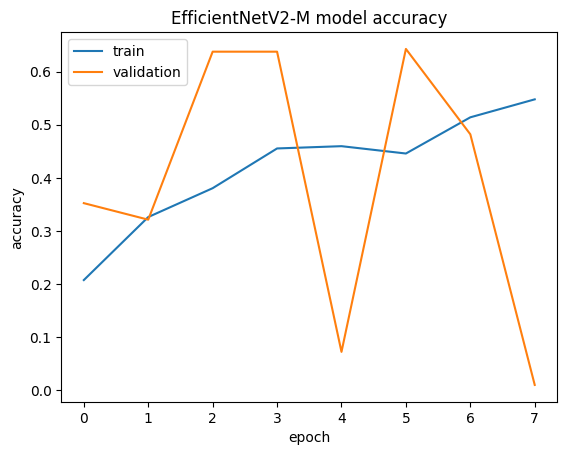

In [29]:
plot_hist(histENV2M, "EfficientNetV2-M")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


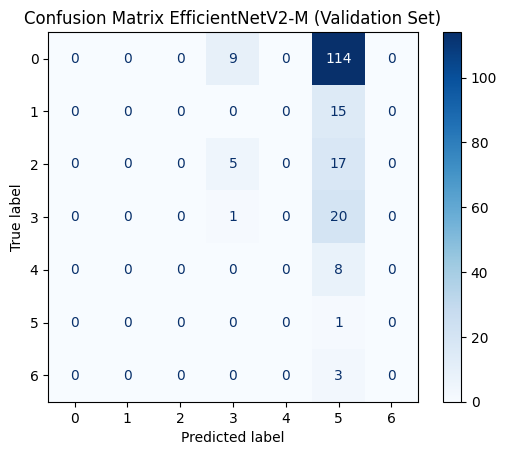

In [30]:
disp = conf_matrix(ds_validate_EN, modelENV2M)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix EfficientNetV2-M (Validation Set)')
plt.show()

### ResNet Models

In [31]:
ds_train_RN = ds_train.map(msp.resNetPrep)
ds_validate_RN = ds_validate.map(msp.resNetPrep)
ds_test_RN = ds_test.map(msp.resNetPrep)

#### ResNet50V2

In [32]:
modelRN50V2 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelRN50V2,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelRN50V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelRN50V2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,622,215 (93.93 MB)

 Trainable params: 24,576,775 (93.75 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [33]:
start_time = time.time()
histRN50V2 = modelRN50V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet50V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.1729 - loss: 2.1095 - val_accuracy: 0.6373 - val_loss: 100.2489
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.2626 - loss: 1.8528 - val_accuracy: 0.6373 - val_loss: 15.1887
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 0.2967 - loss: 1.7854 - val_accuracy: 0.6373 - val_loss: 2.8149
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.3302 - loss: 1.7043 - val_accuracy: 0.0777 - val_loss: 1.7890
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.3261 - loss: 1.6726 - val_accuracy: 0.0777 - val_loss: 1.8227
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.3582 - loss: 1.6500 - val_accuracy: 0.1140 - val_loss: 1.9266
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.3708 - loss: 1.5860 - val_accuracy: 0.0777 - val_loss: 1.9145
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 399s 5s/step - accuracy: 0.3714 - loss: 1.5868 - val_accuracy: 0.0777 - val_lo

In [34]:
loss, accuracy = modelRN50V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.1000 - loss: 1.9607
Overall accuracy on validation set: 7.77%


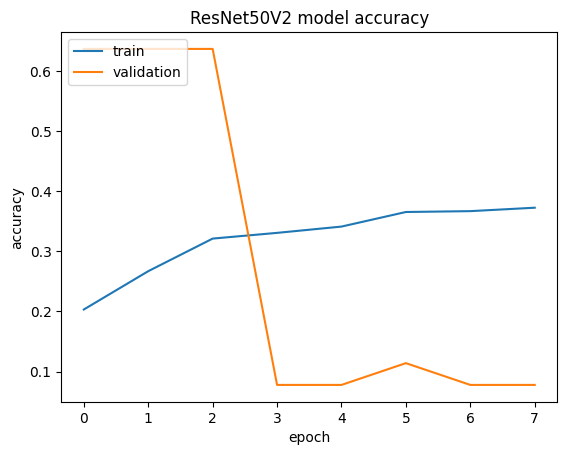

In [35]:
plot_hist(histRN50V2, "ResNet50V2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


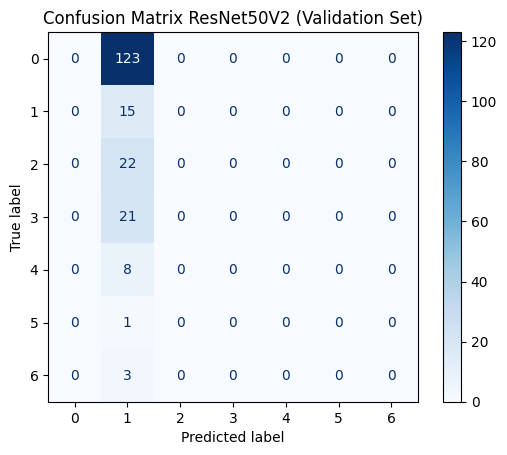

In [36]:
disp = conf_matrix(ds_validate_RN, modelRN50V2)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ResNet50V2 (Validation Set)')
plt.show()

#### ResNet152V2

In [37]:
modelRN152V2 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelRN152V2,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelRN152V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelRN152V2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 2, 2, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,389,063 (226.55 MB)

 Trainable params: 59,245,319 (226.00 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [38]:
start_time = time.time()
histRN152V2 = modelRN152V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet152V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 757s 9s/step - accuracy: 0.1830 - loss: 2.1151 - val_accuracy: 0.6373 - val_loss: 423.4541
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 620s 9s/step - accuracy: 0.2389 - loss: 1.8401 - val_accuracy: 0.0777 - val_loss: 121.4976
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 624s 9s/step - accuracy: 0.3265 - loss: 1.6953 - val_accuracy: 0.6373 - val_loss: 203.5069
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 607s 9s/step - accuracy: 0.3203 - loss: 1.7122 - val_accuracy: 0.6373 - val_loss: 13.1449
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 636s 9s/step - accuracy: 0.3703 - loss: 1.5922 - val_accuracy: 0.6373 - val_loss: 11.5410
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 623s 9s/step - accuracy: 0.4130 - loss: 1.5478 - val_accuracy: 0.6373 - val_loss: 2.9771
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 621s 9s/step - accuracy: 0.4215 - loss: 1.4799 - val_accuracy: 0.0155 - val_loss: 2.0578
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 620s 9s/step - accuracy: 0.4167 - loss: 1.4474 - val_accuracy: 0.0155 - v

In [39]:
loss, accuracy = modelRN152V2.evaluate(ds_validate_RN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step - accuracy: 0.0084 - loss: 3.4328
Overall accuracy on validation set: 1.55%


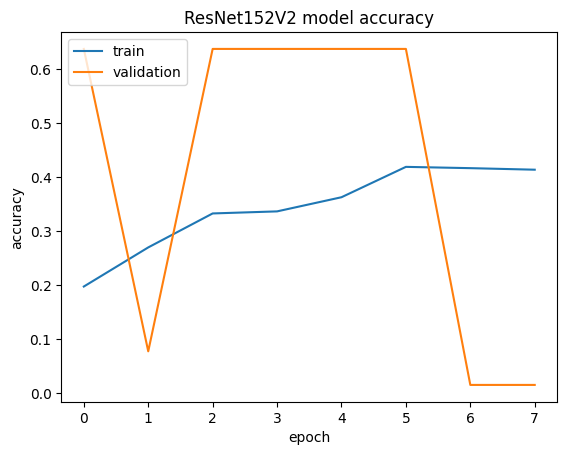

In [40]:
plot_hist(histRN152V2, "ResNet152V2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


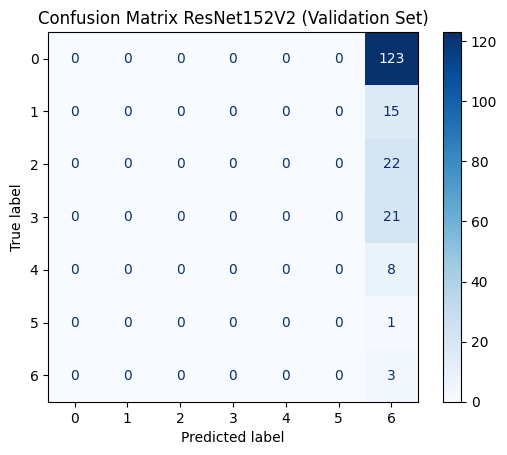

In [41]:
disp = conf_matrix(ds_validate_RN, modelRN152V2)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ResNet152V2 (Validation Set)')
plt.show()

### Inception Models

#### InceptionV3

InceptionV3 requires images sizes of minimum 75x75, therefore this model was not applied to the dataset in this experiment.

### DenseNet Models

In [42]:
ds_train_DN = ds_train.map(msp.denseNetPrep)
ds_validate_DN = ds_validate.map(msp.denseNetPrep)
ds_test_DN = ds_test.map(msp.denseNetPrep)

#### DenseNet121

In [43]:
modelDN121 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelDN121,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelDN121.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN121.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,570,631 (28.88 MB)

 Trainable params: 7,486,983 (28.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [44]:
start_time = time.time()
histDN121 = modelDN121.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet121 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.2012 - loss: 2.1791 - val_accuracy: 0.1088 - val_loss: 2.9913
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2814 - loss: 1.7483 - val_accuracy: 0.0777 - val_loss: 1.9956
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3372 - loss: 1.6640 - val_accuracy: 0.0777 - val_loss: 1.7927
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.3764 - loss: 1.5746 - val_accuracy: 0.0777 - val_loss: 5.7013
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4075 - loss: 1.5492 - val_accuracy: 0.6373 - val_loss: 7.3252
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4022 - loss: 1.5475 - val_accuracy: 0.6373 - val_loss: 5.6379
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4164 - loss: 1.4704 - val_accuracy: 0.6373 - val_loss: 29.8673
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4129 - loss: 1.4288 - val_accuracy: 0.0155 - val_loss

In [45]:
loss, accuracy = modelDN121.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 430ms/step - accuracy: 0.0084 - loss: 165.4583
Overall accuracy on validation set: 1.55%


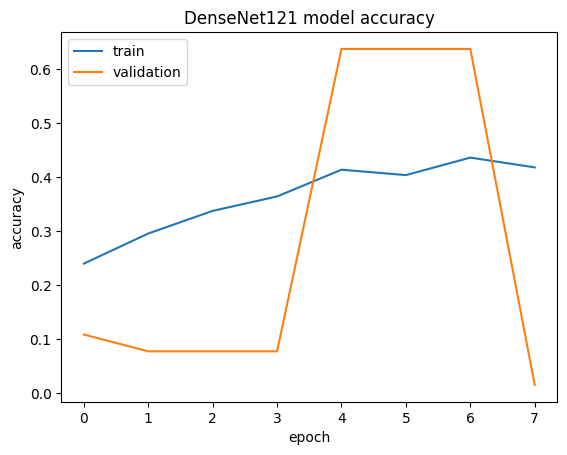

In [46]:
plot_hist(histDN121, "DenseNet121")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


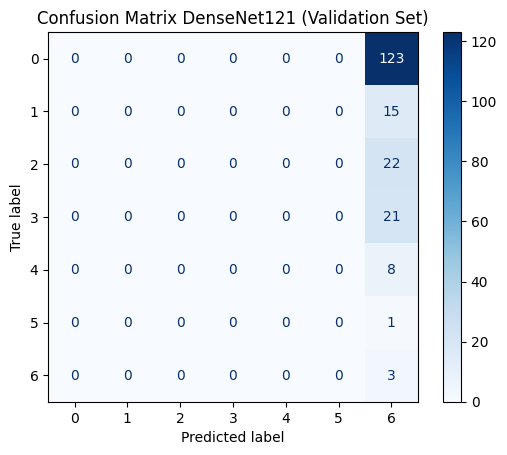

In [47]:
disp = conf_matrix(ds_validate_DN, modelDN121)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix DenseNet121 (Validation Set)')
plt.show()

#### DenseNet201

In [48]:
modelDN201 = models.Sequential([
    layers.Input(shape=(HEIGHT,WIDTH,CHANNELS)),
    data_aug_layers,
    base_modelDN201,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelDN201.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN201.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 2, 2, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,313,863 (73.68 MB)

 Trainable params: 19,084,807 (72.80 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [49]:
start_time = time.time()
histDN201 = modelDN201.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.1467 - loss: 2.1884 - val_accuracy: 0.0415 - val_loss: 4.2149
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.1299 - loss: 1.9461 - val_accuracy: 0.0415 - val_loss: 1.9957
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.1438 - loss: 1.9461 - val_accuracy: 0.1088 - val_loss: 1.9431
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.1521 - loss: 1.9458 - val_accuracy: 0.1088 - val_loss: 1.9451
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.1505 - loss: 1.9459 - val_accuracy: 0.1088 - val_loss: 1.9440
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.1212 - loss: 1.9461 - val_accuracy: 0.1140 - val_loss: 1.9458
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.1258 - loss: 1.9460 - val_accuracy: 0.6373 - val_loss: 1.9434
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.1505 - loss: 1.9459 - val_accuracy: 0.0155 - val_loss:

In [50]:
loss, accuracy = modelDN201.evaluate(ds_validate_DN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.0084 - loss: 1.9449
Overall accuracy on validation set: 1.55%


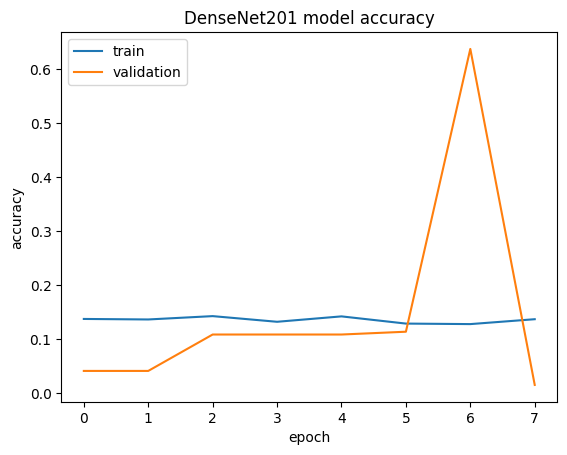

In [51]:
plot_hist(histDN201, "DenseNet201")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


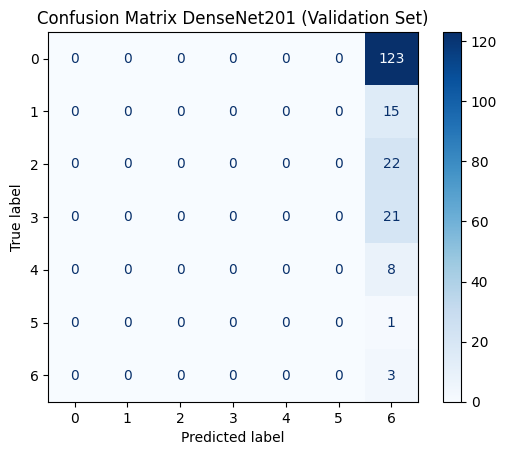

In [52]:
disp = conf_matrix(ds_validate_DN, modelDN201)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix DenseNet201 (Validation Set)')
plt.show()